In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import mne
import warnings
import datetime


from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from keras.constraints import max_norm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from scipy.fft import rfft, rfftfreq



np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 


#%load_ext tensorboard
#%tensorboard --logdir logs

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [27]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [28]:
N_S = 10
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

X,Y = Extract_data_from_subject(root_dir,N_S,datatype)

In [29]:
Subj = Select_time_window(X = X, t_start = Tstart, t_end = Tend, fs = fs)

In [30]:
X, Y = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Vis']])

In [31]:
#X_2, Y_2 = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Inner']])

In [32]:
#X = np.concatenate((X_1, X_2), axis=0)
#Y = np.concatenate((Y_1, Y_2), axis=0)

In [33]:
#input_shape = (X.shape[1],X.shape[2],1)
#print(input_shape)

In [34]:
# one-hot encoding
Y[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = Y[:,1]
y = pd.get_dummies(labels)


In [35]:
X.shape
reshaped_data = X[1]
#reshaped_data.shape
X.shape

(240, 128, 512)

In [36]:
#plt.plot(X[1,:,:]);

In [37]:
X_resize = X * (10**4)
#plt.plot(X_resize[1,:,:]);

In [27]:
# one-hot encoding
Y[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels_1 = Y[:,1]
y = pd.get_dummies(labels_1)

In [28]:
X_resize = X * (10**4)

### FFT
We will convert the signal into a power spectral density plot and select windows of frequencies that may be significant to our model

In [29]:
#Count the number of samples in each recording, it should be 2sec x 256Hz = 512
N = X_resize.shape[2]
N

512

In [30]:
#Run a FFT on the each channel of each recording, and get frequencies
samples_fft = rfft(X_resize)
samples_freq = rfftfreq(N, 1/fs)
samples_fft.shape

(240, 128, 257)

In [31]:
magnitude_spectrum = np.abs(samples_fft)

In [32]:
magnitude_spectrum.shape

(240, 128, 257)

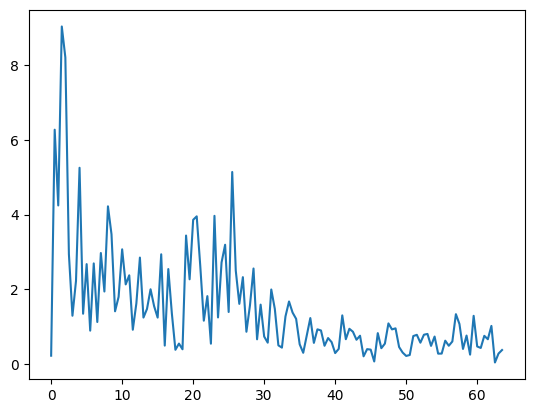

In [33]:
plt.plot(samples_freq[:fs//2], np.abs(samples_fft[0,0,:fs//2]))
plt.show()

## PCA

In [34]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming samples_fft is your data with shape (480, 128, 257)
n_samples, n_channels, n_sampling_points = magnitude_spectrum.shape

# Reshape the data for PCA
samples_fft_reshaped = magnitude_spectrum.reshape(n_samples * n_sampling_points, n_channels)

retain_channels = 64
pca = PCA(n_components=retain_channels)
fft_pca = pca.fit_transform(samples_fft_reshaped)




In [35]:
samples_fft_reshaped.shape

(61680, 128)

In [36]:
fft_pca.shape

(61680, 64)

In [37]:
# Assuming fft_pca has shape (61440, 64)
fft_pca_reshaped = fft_pca.reshape(n_samples, retain_channels, n_sampling_points)

In [38]:
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components needed for 80% variance retention
target_variance_percentage = 80
num_components_for_target_variance = np.argmax(cumulative_explained_variance >= target_variance_percentage / 100) + 1

# Use the identified number of components
pca = PCA(n_components=num_components_for_target_variance)
fft_pca_target_variance = pca.fit_transform(samples_fft_reshaped)

In [39]:
# Assuming fft_pca has shape (61440, 64)
fft_pca = fft_pca_target_variance.reshape(n_samples, 25, n_sampling_points)

ValueError: cannot reshape array of size 1171920 into shape (240,25,257)

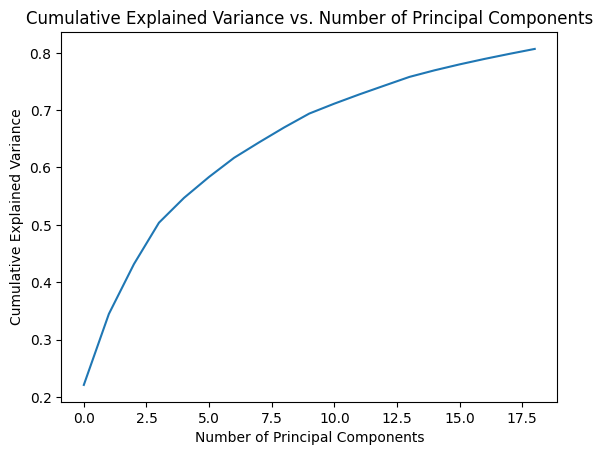

In [43]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

In [ ]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Convert explained variance ratio to percentage
explained_variance_percentage = explained_variance_ratio * 100

# Plot the explained variance percentage for each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_percentage) + 1), explained_variance_percentage)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance Percentage for Each Principal Component')
plt.show()

# Create a box plot to visualize the distribution of variances
plt.figure(figsize=(10, 6))
plt.boxplot(explained_variance_percentage)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Distribution of Explained Variance Percentage Across Principal Components')
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_1, X_2, Y_1, Y_2 are your datasets with four labels

# Perform train-test split for X_1 and Y_1
#X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resize_1, y_1, test_size=0.2, random_state=0)

# Perform train-test split for X_2 and Y_2
#X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_resize_2, y_2, test_size=0.2, random_state=0)



In [ ]:
# Combine the results for X and Y for the test set
#X_test = np.concatenate((X_test_1, X_test_2), axis=0)
#y_test = np.concatenate((y_test_1, y_test_2), axis=0)

#X_train_ = np.concatenate((X_train_1, X_train_2), axis=0)
#y_train_ = np.concatenate((y_train_1, y_train_2), axis=0)

In [40]:
# Perform train-validation split for the combined training set
#X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.1,random_state=0)

In [41]:
# split data into train and test set
X_train_, X_test, y_train_, y_test = train_test_split(fft_pca, y, test_size=0.2)


ValueError: Found input variables with inconsistent numbers of samples: [61680, 240]

In [42]:
# Assuming X_train and y_train are your training data
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.1, random_state=0)


NameError: name 'X_train_' is not defined

In [ ]:
X_train.shape

## 2. Implement CNN

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],1)
print(input_shape)

In [ ]:
'''Adam_ = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001)


def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer 
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu', input_shape = input_shape, strides = (1,2)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu'))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(3000, activation='relu'))
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = 'adam', 
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

model = create_cnn(input_shape)

model.summary() 
'''

In [ ]:
Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
# L1_ = tf.keras.regularizers.L1(l1=0.0005)

def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(32, kernel_size = (1,25), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
#     model.add(layers.Conv2D(8, kernel_size = (128,1), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))    
    # depthwise layer
    model.add(layers.DepthwiseConv2D((25,1), padding = 'valid', activation='relu'))
    # adds max pooling layer
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(200, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Add a second fully connected layer 
    model.add(layers.Dense(50, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5))
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = Adam_, # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

model = create_cnn(input_shape)

model.summary()       

## EEGNET Version

In [ ]:
def EEGNet(input_shape): 
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, kernel_size = (1,25), padding = 'same', input_shape = input_shape))
    model.add(layers.BatchNormalization())
    
    model.add(layers.DepthwiseConv2D((25,1), depth_multiplier = 2, depthwise_constraint = max_norm(1.)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 4)))    
    model.add(layers.SpatialDropout2D(0.25))
    
    model.add(layers.SeparableConv2D(16, kernel_size = (1,16), padding = 'same'))
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 8)))    
    model.add(layers.SpatialDropout2D(0.25))
              
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer = 'adam', # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        ) 
              
    return model

model = EEGNet(input_shape)

model.summary() 


In [ ]:
# Early Stopping    
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Reduce Learning Rate
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='auto',
    min_lr=0.00001,
)

# Train model 
def fit_evaluate(X_train, X_val,  y_train, y_val, epochs = 50, batch_size = 16): 
    model = EEGNet(input_shape)
    results = model.fit(X_train, y_train, epochs, batch_size, verbose= 1, callbacks=[EarlyStopping, ReduceLR], validation_split = 0.1)
    print("Val Score: ", model.evaluate(X_val, y_val))
    
    return results


## Plotting Results

In [ ]:
n_folds = 5
epochs = 50
batch_size = 16

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
train_fold = []
val_fold = []
model_history = []

for train_ind, val_ind in skf.split(X_train, np.argmax(y_train, axis=1)):
    train_fold.append(train_ind)
    val_fold.append(val_ind)

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    
    X_train_i = X_train[train_fold[i]]
    y_train_i = y_train.values[train_fold[i]]  # Convert to NumPy array
    
    X_val_i = X_train[val_fold[i]]
    y_val_i = y_train.values[val_fold[i]]  # Convert to NumPy array
    
    model_history.append(fit_evaluate(X_train_i, X_val_i, y_train_i, y_val_i, epochs, batch_size))
    
    print("=======" * 12, end="\n\n\n")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f'Model {i+1}')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Find the fold with the best validation accuracy
best_fold_idx = np.argmax([np.max(model_history[i].history['val_accuracy']) for i in range(n_folds)])

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot the best fold
ax[0].plot(model_history[best_fold_idx].history['accuracy'], label=f'Fold {best_fold_idx + 1} Train')
ax[0].plot(model_history[best_fold_idx].history['val_accuracy'], label=f'Fold {best_fold_idx + 1} Validation')

ax[1].plot(model_history[best_fold_idx].history['loss'], label=f'Fold {best_fold_idx + 1} Train')
ax[1].plot(model_history[best_fold_idx].history['val_loss'], label=f'Fold {best_fold_idx + 1} Validation')

# Set common titles and labels
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize history
# Loss
for i in range(n_folds):
    plt.plot(model_history[i].history['val_loss'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.show()


# Validation Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['val_accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()



In [ ]:
# Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
#%tensorboard --logdir logs/fit

In [ ]:
pred_y = model.predict(
    X_test,
    verbose =1
)

In [ ]:
#print(pred_y)

In [ ]:
score = model.evaluate(
    X_test,
    y_test,
    batch_size = 24,
    verbose =2
)

## Further Data Exploration - Topoplots, Channel Localization

In [ ]:
Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
info = mne.create_info(ch_names=X.shape[1], sfreq=256, ch_types='eeg')


In [ ]:
mapping = {str(i): ch_name for i, ch_name in enumerate(montage.ch_names)}
info.rename_channels(mapping)

In [ ]:
mapping = {ch_name: 'eeg' for ch_name in montage.ch_names}
info.set_channel_types(mapping)

In [ ]:
mean_data = np.mean(X, axis=0)

In [ ]:
# Create a RawArray object using reshaped data
raw = mne.io.RawArray(X[1], info)

# Plot the sensors with the applied montage
#fig = raw.plot_sensors(show_names=True)


In [ ]:
#raw.plot(n_channels=50, color = 'steelblue',show_scrollbars= False, show_scalebars= False, time_format="float")


In [ ]:
import mne
import numpy as np

# Assuming 'raw' is your Raw object

# Number of time segments
num_segments = 4
segment_size = raw.n_times // num_segments

# Plot topoplots for each segment
for i in range(num_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < num_segments - 1 else raw.n_times
    mean_data = np.mean(raw.get_data()[:, start_idx:end_idx], axis=1)
    
    info = raw.info

    #mne.viz.plot_topomap(mean_data, info, show=True, contours= True, res=300, sensors='k.', size=5, vlim =(-0.00001,0.00001))


In [2]:
acc_inner = np.array([0.35, 0.29, 0.17, 0.27, 0.33, 0.27, 0.31, 0.15, 0.27, 0.25])
acc_visual = np.array([0.19, 0.25, 0.21, 0.23, 0.25, 0.19, 0.27, 0.27, 0.25, 0.21])
acc_both = np.array([0.21, 0.25, 0.19, 0.24, 0.21, 0.22, 0.21, 0.21, 0.18, 0.23])



std_value = np.std(acc_both)
print("Standard Deviation:", std_value)


mean = np.mean(acc_both)
print("Mean:", mean)


NameError: name 'np' is not defined